In [1]:
import os
from email.parser import Parser
import numpy as np
import pandas as pd
import re
import nltk

# import the pretrained Bert tokenizer
import transformers
from transformers import BertTokenizer, TFBertModel
from transformers import InputExample, InputFeatures

# from sklearn import metrics, manifold
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
# import train/val/test data from the data exploration part

data_prep=np.load('data_prep_bert.npz')

train_reviews=data_prep['train_reviews']
train_segments=data_prep['train_segments']
train_masks=data_prep['train_masks']
train_label=data_prep['train_label']

val_reviews=data_prep['val_reviews']
val_segments=data_prep['val_segments']
val_masks=data_prep['val_masks']
val_label=data_prep['val_label']

test_reviews=data_prep['test_reviews']
test_segments=data_prep['test_segments']
test_masks=data_prep['test_masks']
test_label=data_prep['test_label']

In [3]:
# function to convert the data into tf.tensor inputs 
# for the training model

def example_to_features(input_ids,attention_masks,token_type_ids,label):
    return {'input_ids':input_ids,
            'attention_mask': attention_masks,
            'token_type_ids': token_type_ids},label

train_ds=tf.data.Dataset.from_tensor_slices(
    (train_reviews,train_masks,train_segments,train_label)).map(
    example_to_features).shuffle(100).batch(4)

val_ds=tf.data.Dataset.from_tensor_slices(
    (val_reviews,val_masks,val_segments,val_label)).map(
    example_to_features).shuffle(100).batch(4)

test_ds=tf.data.Dataset.from_tensor_slices(
    (test_reviews,test_masks,test_segments,test_label)).map(
    example_to_features).batch(4)

# 1. Bert with customed head for finetuning

In [4]:

model0=TFBertModel.from_pretrained('bert-base-uncased')

model0.trainable=False

model0.summary()


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 0
Non-trainable params: 109,482,240
_________________________________________________________________


In [5]:
def head(training=None):
    
    # create the inputs for the BERT model
    max_seq_len=512
    inp_ids=tf.keras.layers.Input(
        (max_seq_len),dtype=tf.int64,name='input_ids')
    att_mask=tf.keras.layers.Input(
        (max_seq_len),dtype=tf.int64,name='attention_mask')
    seg_ids=tf.keras.layers.Input(
        (max_seq_len),dtype=tf.int64,name='token_type_ids')

    inp_dict={'input_ids':inp_ids,
              'attention_mask':att_mask,
              'token_type_ids':seg_ids}
    
    output=model0(inp_dict) # from the untrained BERT network
    x=tf.keras.layers.Dropout(0.2)(output[1],training=training) 
    x=tf.keras.layers.Dense(200,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.2)(x,training=training)
    x=tf.keras.layers.Dense(2,activation='sigmoid')(x)

    model=tf.keras.models.Model(inputs=inp_dict,outputs=x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2E-5),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy'])
    
    return model


Train the head (classifier)

In [6]:
mc=ModelCheckpoint(
    'model_param/Bert_custom_head_fine_tune_only.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

num_epochs=10

classifier=head(training=True)
history=classifier.fit(
    train_ds,epochs=num_epochs,
    callbacks=[mc],
    validation_data=val_ds) 
    # such that # validation sample is 0.2 of the total samples


Epoch 1/10
17500/17500 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.6928
Epoch 00001: val_loss improved from inf to 0.56501, saving model to model_param\Bert_custom_head_fine_tune_only.h5
17500/17500 [==============================] - 2690s 153ms/step - loss: 0.5894 - accuracy: 0.6928 - val_loss: 0.5650 - val_accuracy: 0.7137
Epoch 2/10
17500/17500 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.7105
Epoch 00002: val_loss improved from 0.56501 to 0.55316, saving model to model_param\Bert_custom_head_fine_tune_only.h5
17500/17500 [==============================] - 2684s 153ms/step - loss: 0.5632 - accuracy: 0.7105 - val_loss: 0.5532 - val_accuracy: 0.7225
Epoch 3/10
17500/17500 [==============================] - ETA: 0s - loss: 0.5528 - accuracy: 0.7184
Epoch 00003: val_loss improved from 0.55316 to 0.54763, saving model to model_param\Bert_custom_head_fine_tune_only.h5
17500/17500 [==============================] - 2682s 153ms/step - l

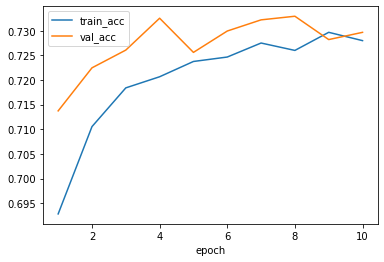

In [8]:
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['accuracy'],label='train_acc')
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['val_accuracy'],label='val_acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

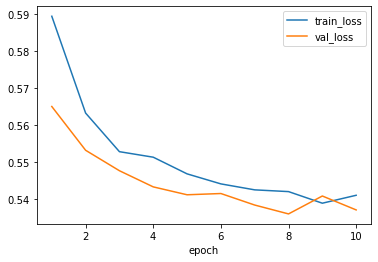

In [9]:
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['loss'],label='train_loss')
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# # save the model weights
# classifier.save_weights('trained_classifier')

# 5. Predictions and Evaluations

In [10]:
bert=head(training=False)
bert.load_weights('model_param/Bert_custom_head_fine_tune_only.h5')

bert.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2E-5),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy'])


In [11]:
bert.evaluate(test_ds)

3750/3750 [==============================] - 399s 106ms/step - loss: 0.5204 - accuracy: 0.742630s - loss: 0.5190 - a - ETA: 28s -  - ETA: 25s - loss: 0.5192 - accu - ETA: 24s - loss: 0.5193 - ETA: 2 - ETA: 18s - loss: 0.5191 - accuracy: 0.743 - ETA: 18s - loss: 0.5191 - accurac - ETA: 17s - lo - ETA: 2s - loss: 0.5 - ETA: 1s - loss: 0.5209 - accura - ETA: 0s - loss: 0.520


[0.5203744173049927, 0.7426000237464905]

In [ ]:
# metrics.rand_score(test_sentence_label, label_pred)